In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [132]:
df = pd.read_csv("México_DesviaciónEstandar_Limpio.csv")
df['host_response_rate'] = (
    pd.to_numeric(
        df['host_response_rate']
        .astype(str)   
        .str.strip()   
        .str.rstrip('%'),
        errors='coerce'  
    )
)
df['host_acceptance_rate'] = (
    pd.to_numeric(
        df['host_acceptance_rate']
        .astype(str)   
        .str.strip()   
        .str.rstrip('%'),
        errors='coerce'  
    )
)

df['host_response_rate'].fillna(0, inplace=True)
df.dropna(subset=['host_response_rate'], inplace=True)

df['host_acceptance_rate'].fillna(0, inplace=True)
df.dropna(subset=['host_acceptance_rate'], inplace=True)

df["host_response_rate"]
df['host_acceptance_rate']

/var/folders/p0/qzxt_2qj2wqcvfvmsw_vz06c0000gn/T/ipykernel_3121/3147546854.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['host_response_rate'].fillna(0, inplace=True)
/var/folders/p0/qzxt_2qj2wqcvfvmsw_vz06c0000gn/T/ipykernel_3121/3147546854.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

0        1.00
1        0.93
2        0.57
3        1.00
4        1.00
         ... 
26577    1.00
26578    1.00
26579    1.00
26580    1.00
26581    1.00
Name: host_acceptance_rate, Length: 26582, dtype: float64

In [ ]:
# def remove_outliers(df, columns, factor=1.5):
#     """
#     Elimina outliers de las columnas especificadas usando el método IQR.
    
#     Parámetros:
#       - df: DataFrame a limpiar.
#       - columns: Lista de columnas en las que se eliminarán los outliers.
#       - factor: Multiplicador del IQR (por defecto 1.5).
      
#     Retorna un DataFrame sin los outliers en las columnas indicadas.
#     """
#     df_clean = df.copy()
#     for col in columns:
#         Q1 = df_clean[col].quantile(0.25)
#         Q3 = df_clean[col].quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - factor * IQR
#         upper_bound = Q3 + factor * IQR
#         df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
#     return df_clean

# # Ejemplo de uso:
# # Supongamos que quieres eliminar outliers en las columnas "price", "bathrooms" y "accommodates":
# cols_to_clean = ['host_acceptance_rate', 'price', 'host_response_rate', 'accommodates',
#                'bathrooms', 'host_is_superhost', 'review_scores_cleanliness',
#                'host_identity_verified', 'instant_bookable', 'property_type']
# df_clean = remove_outliers(df, cols_to_clean)

# # Verifica el tamaño del DataFrame antes y después:
# print("Tamaño original:", df.shape)
# print("Tamaño limpio:", df_clean.shape)


In [133]:
# Setting dataframes for each room type
dfEntireHome =df[df["room_type"] == "Entire home/apt"]
dfPrivateRoom = df[df["room_type"] == "Private room"]
dfSharedRoom = df[df["room_type"] == "Shared room"]
dfHotelRoom = df[df["room_type"] == "Hotel room"]


# Regresion Lineal Simple


In [137]:
# ============================
# Funciones de Preprocesamiento
# ============================
def convert_percentage(serie):
    """Convierte cadenas con '%' a valores numéricos."""
    return pd.to_numeric(serie.astype(str).str.strip().str.rstrip('%'), errors='coerce')

def preprocess_df(df):
    if 'host_response_rate' in df.columns:
        df['host_response_rate'] = convert_percentage(df['host_response_rate'])
        df['host_response_rate'].fillna(df['host_response_rate'].mean(), inplace=True)
    if 'host_acceptance_rate' in df.columns:
        df['host_acceptance_rate'] = convert_percentage(df['host_acceptance_rate'])
        df['host_acceptance_rate'].fillna(df['host_acceptance_rate'].mean(), inplace=True)
    
    for col in ['host_is_superhost', 'host_identity_verified', 'instant_bookable']:
        if col in df.columns:
            df[col] = df[col].replace({"t": 1, "f": 0})
    
    if 'property_type' in df.columns and df["property_type"].dtype == object:
        propertyCounts = df["property_type"].value_counts()
        propertyRank = propertyCounts.rank(method='dense', ascending=False).astype(int)
        rank_mapping = propertyRank.to_dict()
        df["property_type"] = df["property_type"].map(rank_mapping)
    
    return df

# ============================
# Cargar y Preprocesar Datos
# ============================
df = pd.read_csv("México_DesviaciónEstandar_Limpio.csv")

df = preprocess_df(df)

# Filtrar por tipo de habitación para crear subconjuntos
dfEntireHome = df[df["room_type"] == "Entire home/apt"].copy()
dfPrivateRoom  = df[df["room_type"] == "Private room"].copy()
dfSharedRoom   = df[df["room_type"] == "Shared room"].copy()
dfHotelRoom = df[df["room_type"] == "Hotel room"].copy()

cols_to_use = ['host_acceptance_rate', 'price', 'host_response_rate', 'accommodates',
               'bathrooms', 'host_is_superhost', 'review_scores_cleanliness',
               'host_identity_verified', 'instant_bookable', 'property_type']

dfEntireHome = dfEntireHome[cols_to_use].copy()
dfPrivateRoom = dfPrivateRoom[cols_to_use].copy()
dfSharedRoom  = dfSharedRoom[cols_to_use].copy()
dfHotelRoom = dfHotelRoom[cols_to_use].copy()

# ============================
# Función para Regresión Lineal Simple
# ============================
def plot_simple_regression(dataframe, indep_col, dep_col="price", title=None):
    X = dataframe[[indep_col]]
    y = dataframe[dep_col]
    
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    
    df_plot = dataframe.copy()
    df_plot["pred"] = y_pred
    df_plot = df_plot.sort_values(indep_col)
    
    if title is None:
        title = f"Regresión Simple: {indep_col} vs {dep_col}"
    
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=df_plot[indep_col], y=df_plot[dep_col], color="blue", label="Datos reales")
    sns.scatterplot(x=df_plot[indep_col], y=df_plot["pred"], color="red", label="Predicción")
    plt.title(title)
    plt.xlabel(indep_col)
    plt.ylabel(dep_col)
    plt.legend()
    plt.show()
    
    r2 = model.score(X, y)
    print(f"Coeficiente de determinación (R²): {r2}")
    print(f"Coeficiente de correlación (sqrt(R²)): {np.sqrt(r2)}")




/var/folders/p0/qzxt_2qj2wqcvfvmsw_vz06c0000gn/T/ipykernel_3121/3873089614.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['host_response_rate'].fillna(df['host_response_rate'].mean(), inplace=True)
/var/folders/p0/qzxt_2qj2wqcvfvmsw_vz06c0000gn/T/ipykernel_3121/3873089614.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on wh

# Entire Home

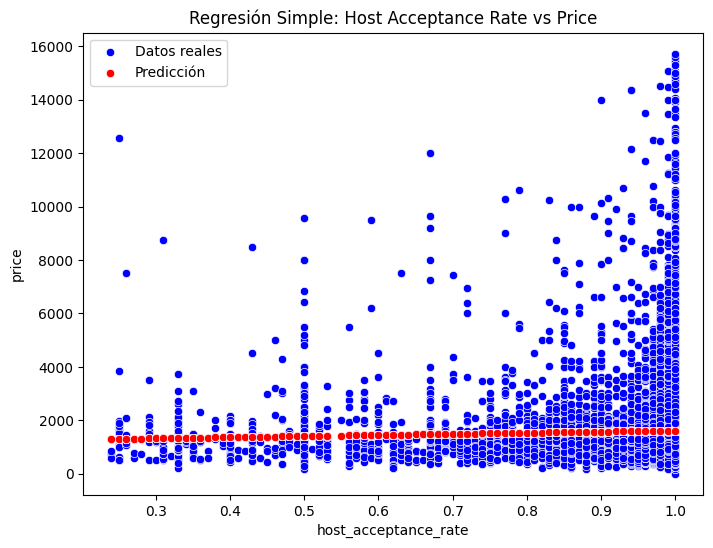

Coeficiente de determinación (R²): 0.0010652988987558398
Coeficiente de correlación (sqrt(R²)): 0.03263891693601122


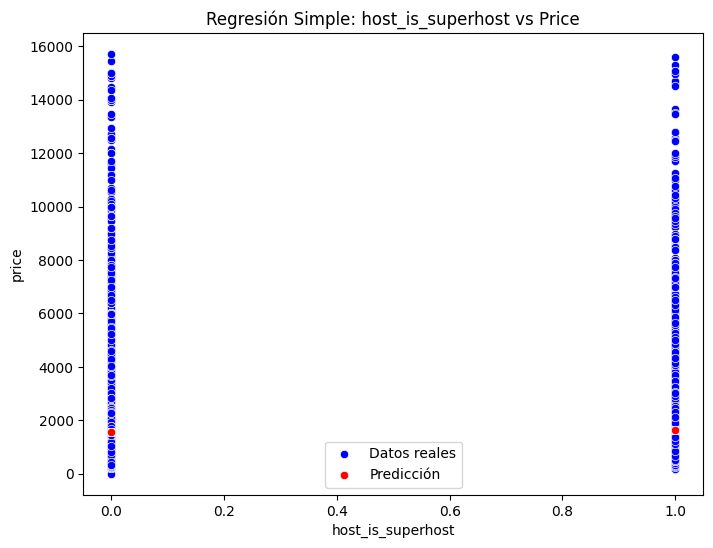

Coeficiente de determinación (R²): 0.001122562633548263
Coeficiente de correlación (sqrt(R²)): 0.033504665847434785


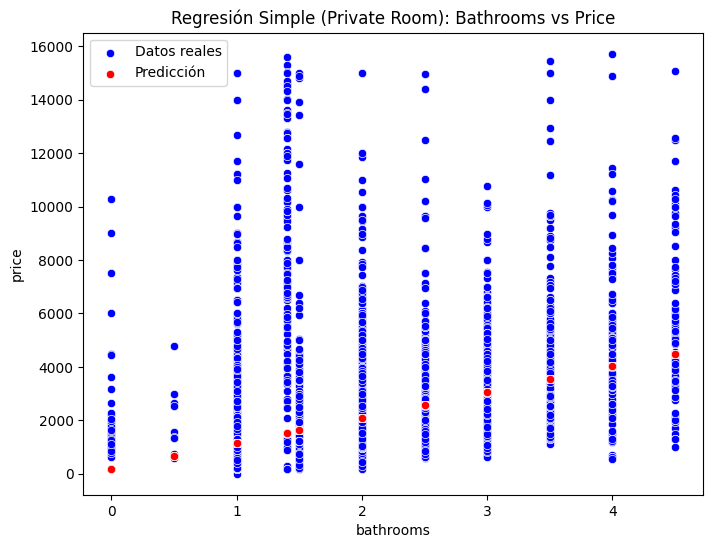

Coeficiente de determinación (R²): 0.20188665949373819
Coeficiente de correlación (sqrt(R²)): 0.449317993734658


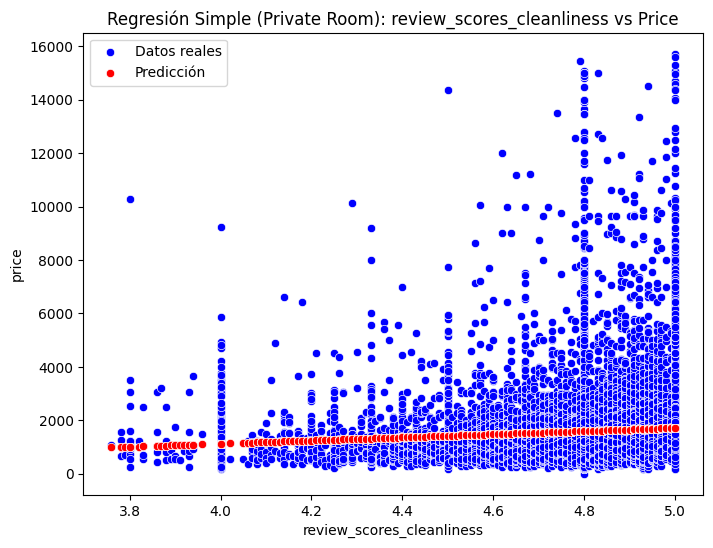

Coeficiente de determinación (R²): 0.0066223016651087985
Coeficiente de correlación (sqrt(R²)): 0.08137752555287485


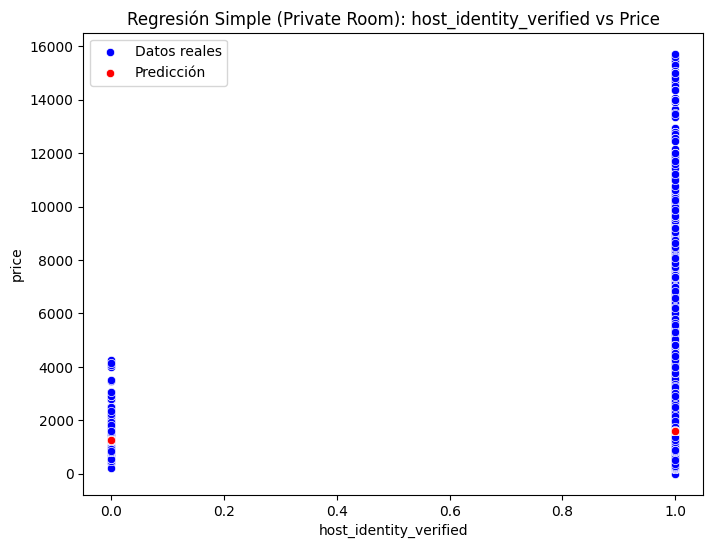

Coeficiente de determinación (R²): 0.0014499461582965223
Coeficiente de correlación (sqrt(R²)): 0.03807815854655425


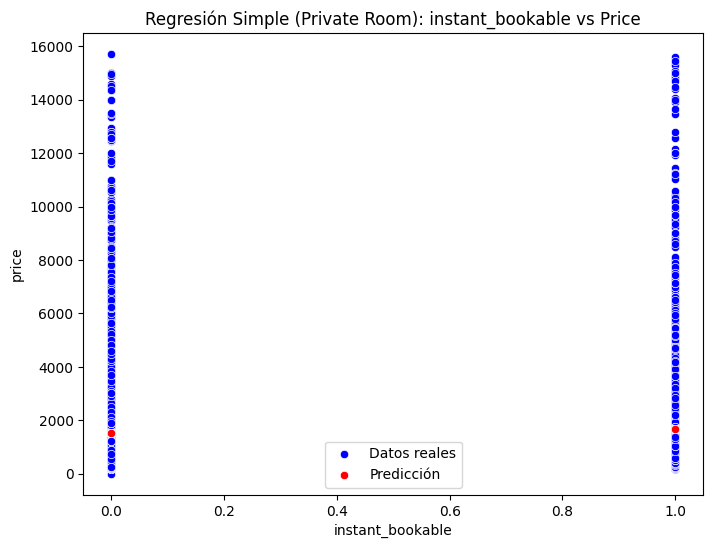

Coeficiente de determinación (R²): 0.0024872199146942497
Coeficiente de correlación (sqrt(R²)): 0.04987203539754769


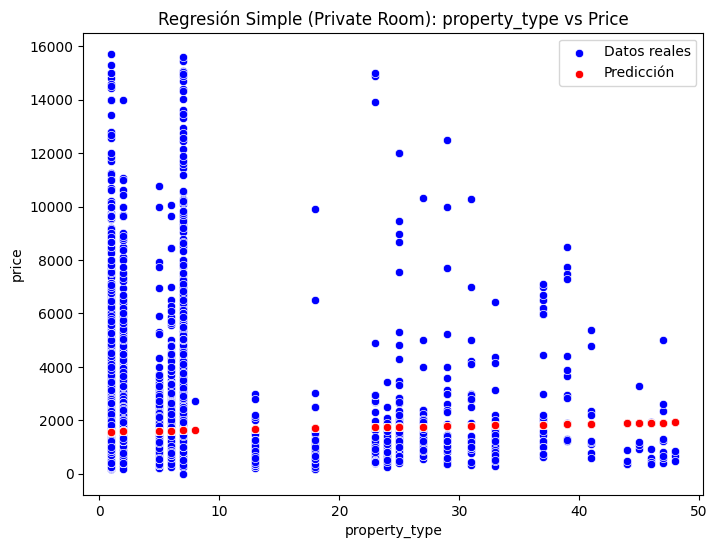

Coeficiente de determinación (R²): 0.0006707066321343103
Coeficiente de correlación (sqrt(R²)): 0.025898004404477003


In [128]:
# Entire Home 
# 
plot_simple_regression(dfEntireHome, indep_col="host_acceptance_rate", dep_col="price",
                       title="Regresión Simple: Host Acceptance Rate vs Price")

# Ejemplo 2: Usar dfEntireHome y comparar usando "property_type" en el eje X
plot_simple_regression(dfEntireHome, indep_col="host_is_superhost", dep_col="price",
                       title="Regresión Simple: host_is_superhost vs Price")

# Ejemplo 3: Usar dfPrivateRoom y comparar usando "host_acceptance_rate" en el eje X
plot_simple_regression(dfEntireHome, indep_col="bathrooms", dep_col="price",
                       title="Regresión Simple (Private Room): Bathrooms vs Price")

plot_simple_regression(dfEntireHome, indep_col="review_scores_cleanliness", dep_col="price",
                       title="Regresión Simple (Private Room): review_scores_cleanliness vs Price")

plot_simple_regression(dfEntireHome, indep_col="host_identity_verified", dep_col="price",
                       title="Regresión Simple (Private Room): host_identity_verified vs Price")

plot_simple_regression(dfEntireHome, indep_col="instant_bookable", dep_col="price",
                       title="Regresión Simple (Private Room): instant_bookable vs Price")

plot_simple_regression(dfEntireHome, indep_col="property_type", dep_col="price",
                       title="Regresión Simple (Private Room): property_type vs Price")

# Private Room

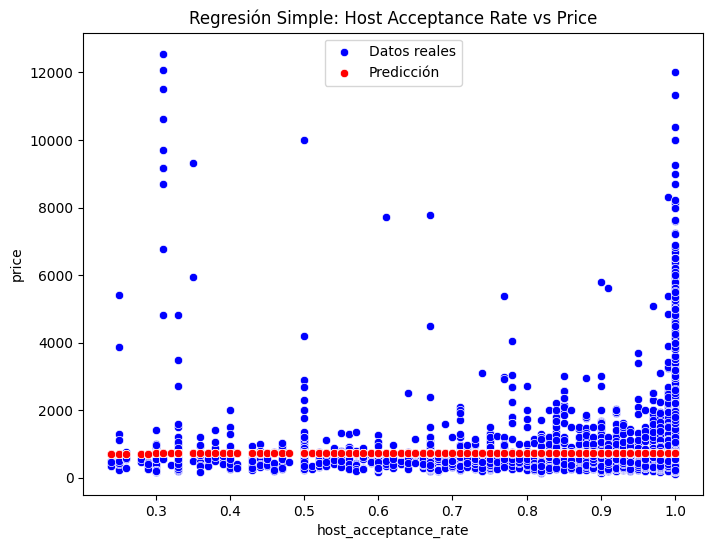

Coeficiente de determinación (R²): 4.8836603977253645e-05
Coeficiente de correlación (sqrt(R²)): 0.00698831910957518


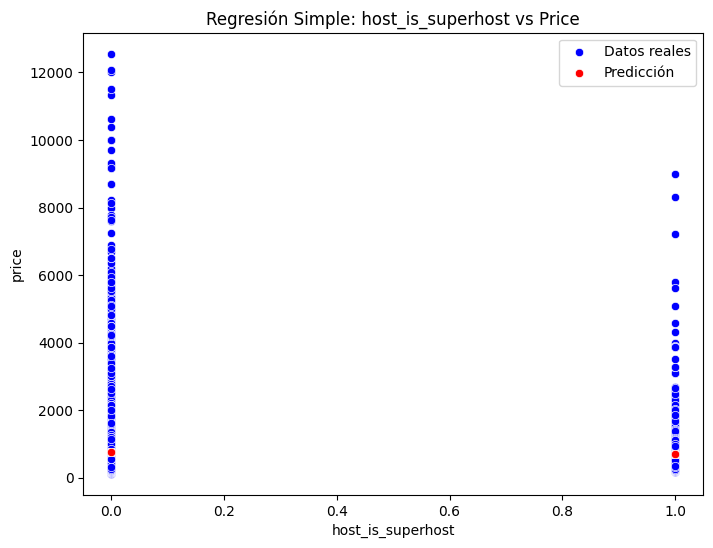

Coeficiente de determinación (R²): 0.0010257169686086476
Coeficiente de correlación (sqrt(R²)): 0.032026816398272366


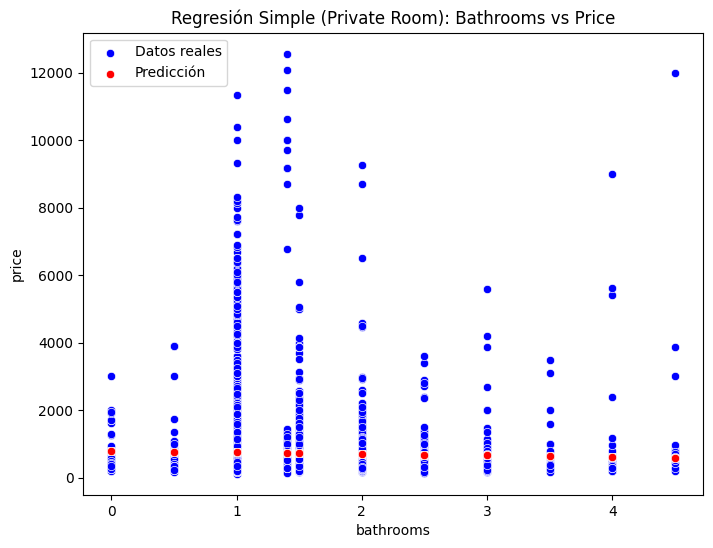

Coeficiente de determinación (R²): 0.000760297362147111
Coeficiente de correlación (sqrt(R²)): 0.027573490206122094


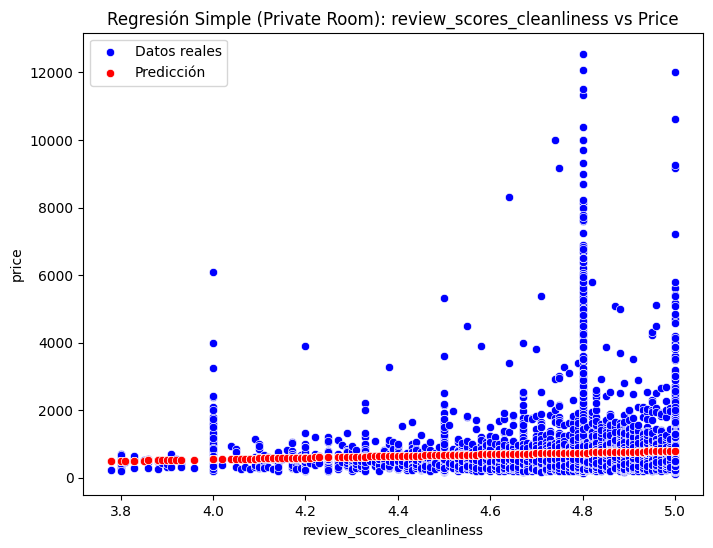

Coeficiente de determinación (R²): 0.004591515894803888
Coeficiente de correlación (sqrt(R²)): 0.06776072531196732


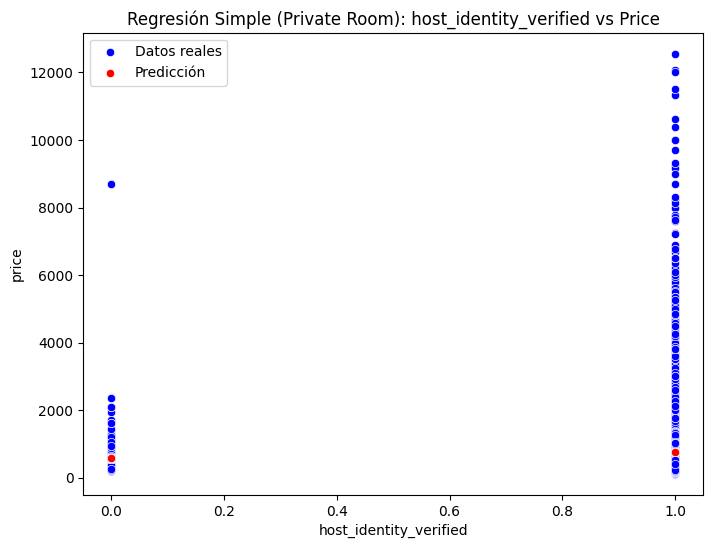

Coeficiente de determinación (R²): 0.002572183759347757
Coeficiente de correlación (sqrt(R²)): 0.05071670099038143


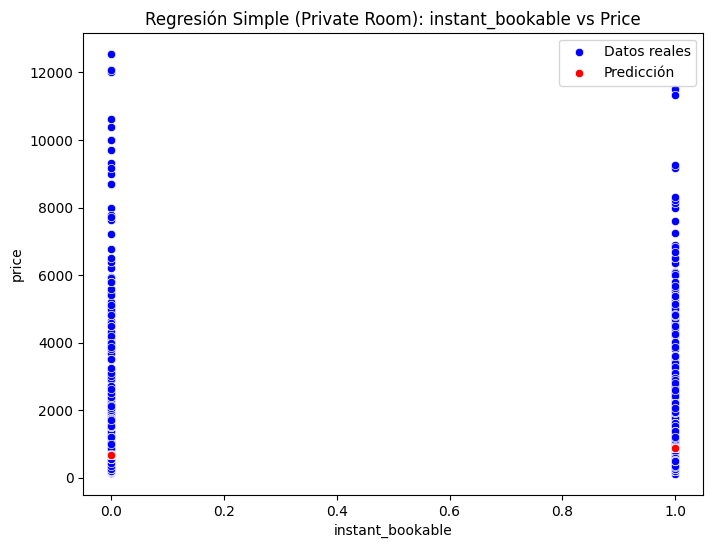

Coeficiente de determinación (R²): 0.015118124885500905
Coeficiente de correlación (sqrt(R²)): 0.12295578427020384


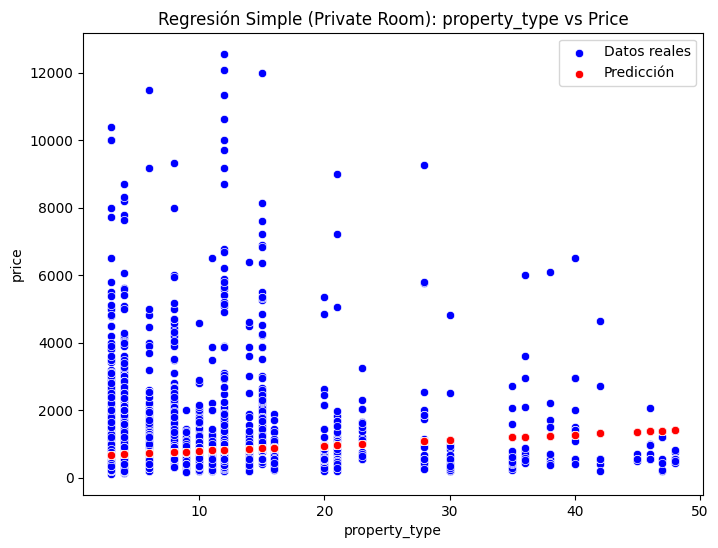

Coeficiente de determinación (R²): 0.014218784959439068
Coeficiente de correlación (sqrt(R²)): 0.1192425467668276


In [129]:
# Private Room
plot_simple_regression(dfPrivateRoom, indep_col="host_acceptance_rate", dep_col="price",
                       title="Regresión Simple: Host Acceptance Rate vs Price")

# Ejemplo 2: Usar dfEntireHome y comparar usando "property_type" en el eje X
plot_simple_regression(dfPrivateRoom, indep_col="host_is_superhost", dep_col="price",
                       title="Regresión Simple: host_is_superhost vs Price")

# Ejemplo 3: Usar dfPrivateRoom y comparar usando "host_acceptance_rate" en el eje X
plot_simple_regression(dfPrivateRoom, indep_col="bathrooms", dep_col="price",
                       title="Regresión Simple (Private Room): Bathrooms vs Price")

plot_simple_regression(dfPrivateRoom, indep_col="review_scores_cleanliness", dep_col="price",
                       title="Regresión Simple (Private Room): review_scores_cleanliness vs Price")

plot_simple_regression(dfPrivateRoom, indep_col="host_identity_verified", dep_col="price",
                       title="Regresión Simple (Private Room): host_identity_verified vs Price")

plot_simple_regression(dfPrivateRoom, indep_col="instant_bookable", dep_col="price",
                       title="Regresión Simple (Private Room): instant_bookable vs Price")

plot_simple_regression(dfPrivateRoom, indep_col="property_type", dep_col="price",
                       title="Regresión Simple (Private Room): property_type vs Price")

# Shared Room

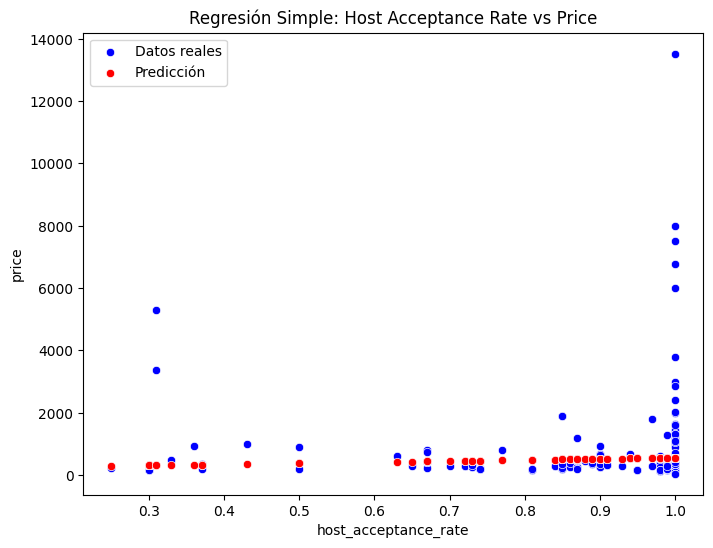

Coeficiente de determinación (R²): 0.006991572344933972
Coeficiente de correlación (sqrt(R²)): 0.08361562261284652


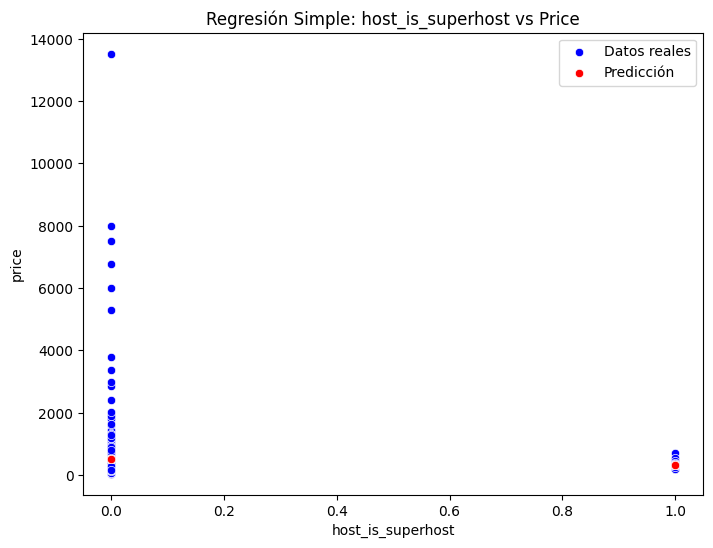

Coeficiente de determinación (R²): 0.002933775550901019
Coeficiente de correlación (sqrt(R²)): 0.054164338368533765


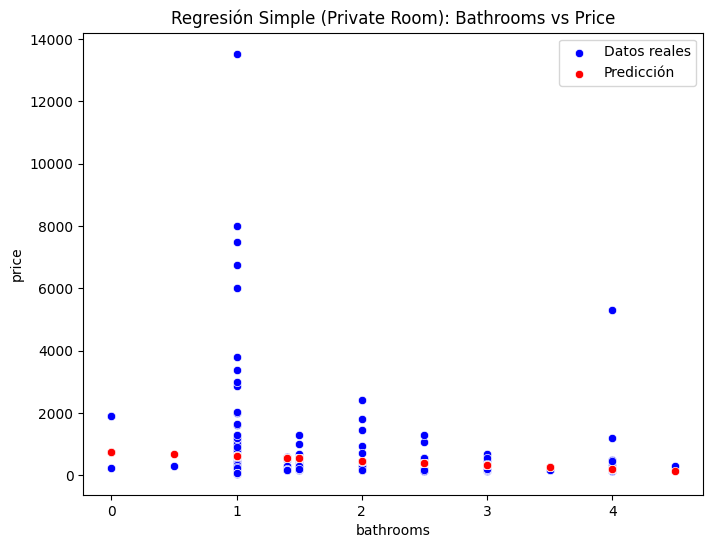

Coeficiente de determinación (R²): 0.014081259306600757
Coeficiente de correlación (sqrt(R²)): 0.11866448207699201


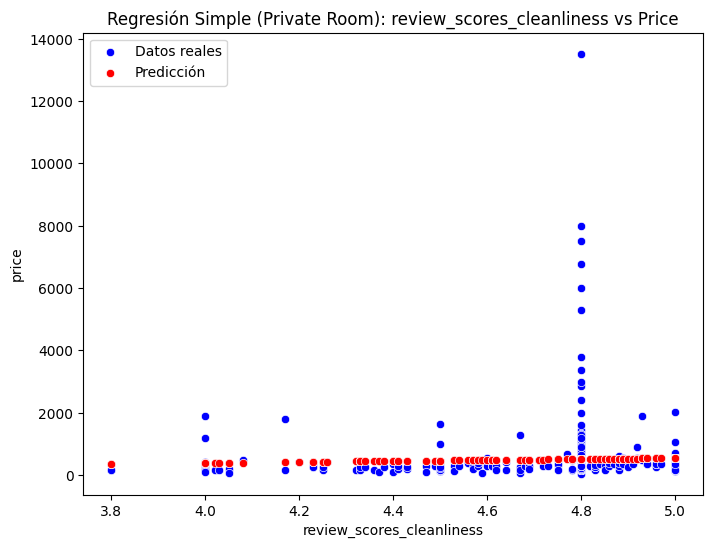

Coeficiente de determinación (R²): 0.0013060217931450957
Coeficiente de correlación (sqrt(R²)): 0.03613892351945608


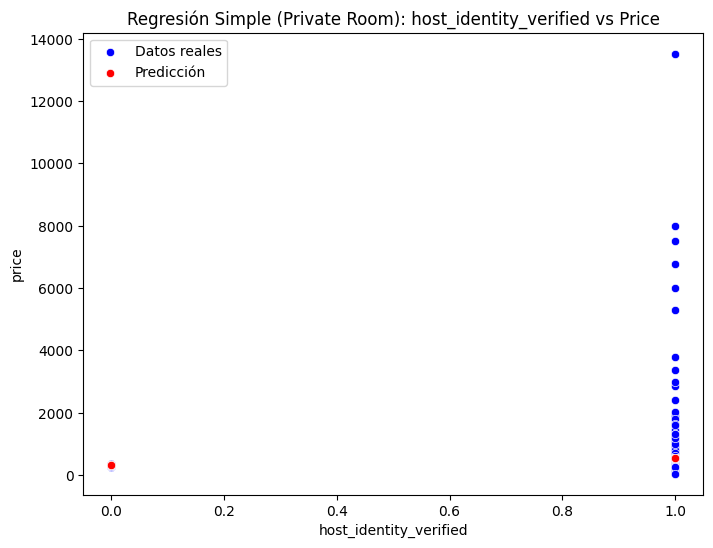

Coeficiente de determinación (R²): 0.007344940015363233
Coeficiente de correlación (sqrt(R²)): 0.0857026254869898


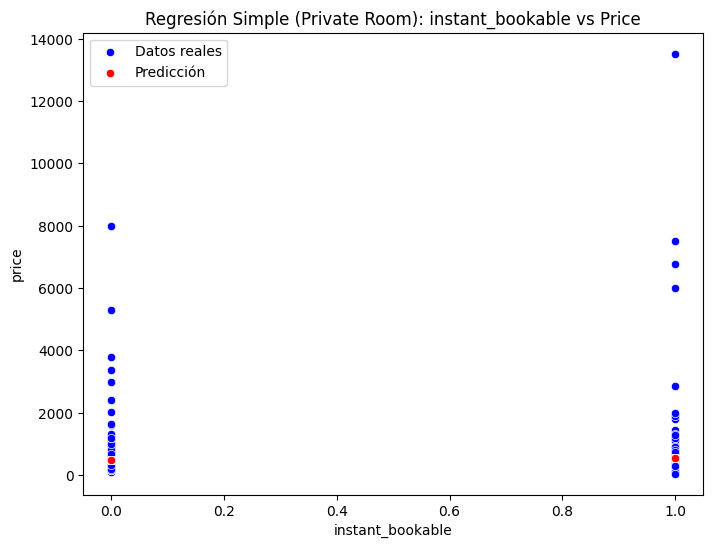

Coeficiente de determinación (R²): 0.0009041916469959554
Coeficiente de correlación (sqrt(R²)): 0.030069779629986575


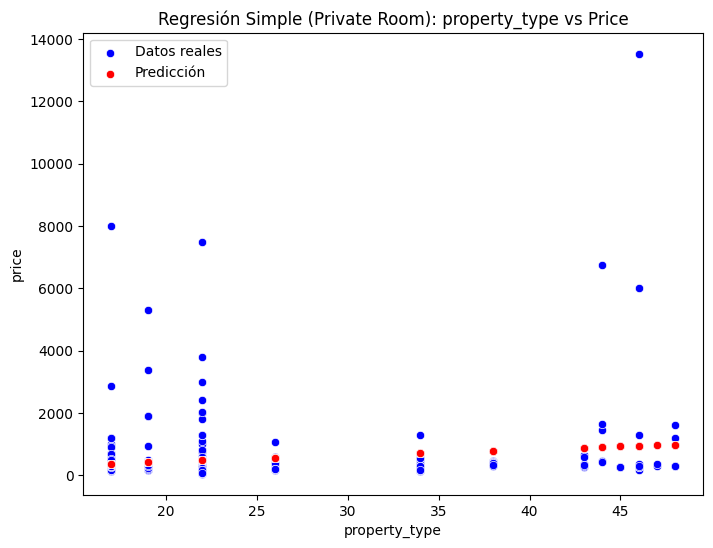

Coeficiente de determinación (R²): 0.024540950569259423
Coeficiente de correlación (sqrt(R²)): 0.15665551560433302


In [130]:
# Private Room
plot_simple_regression(dfSharedRoom, indep_col="host_acceptance_rate", dep_col="price",
                       title="Regresión Simple: Host Acceptance Rate vs Price")

# Ejemplo 2: Usar dfEntireHome y comparar usando "property_type" en el eje X
plot_simple_regression(dfSharedRoom, indep_col="host_is_superhost", dep_col="price",
                       title="Regresión Simple: host_is_superhost vs Price")

# Ejemplo 3: Usar dfPrivateRoom y comparar usando "host_acceptance_rate" en el eje X
plot_simple_regression(dfSharedRoom, indep_col="bathrooms", dep_col="price",
                       title="Regresión Simple (Private Room): Bathrooms vs Price")

plot_simple_regression(dfSharedRoom, indep_col="review_scores_cleanliness", dep_col="price",
                       title="Regresión Simple (Private Room): review_scores_cleanliness vs Price")

plot_simple_regression(dfSharedRoom, indep_col="host_identity_verified", dep_col="price",
                       title="Regresión Simple (Private Room): host_identity_verified vs Price")

plot_simple_regression(dfSharedRoom, indep_col="instant_bookable", dep_col="price",
                       title="Regresión Simple (Private Room): instant_bookable vs Price")

plot_simple_regression(dfSharedRoom, indep_col="property_type", dep_col="price",
                       title="Regresión Simple (Private Room): property_type vs Price")

# Hotel Room

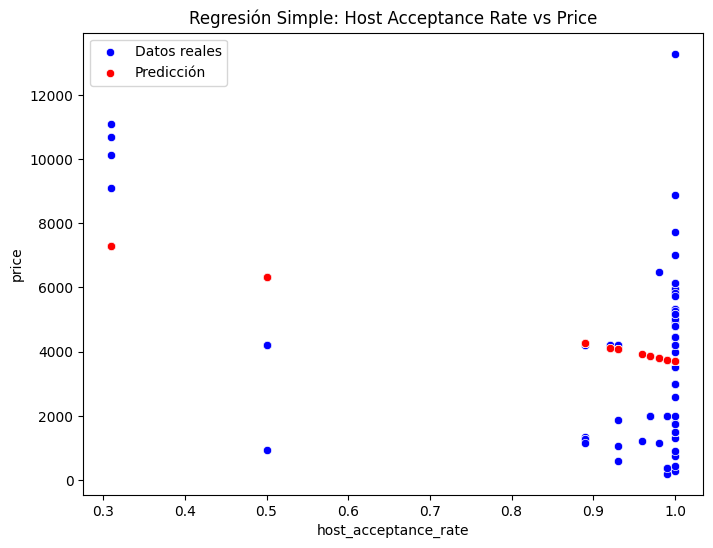

Coeficiente de determinación (R²): 0.11631643859365381
Coeficiente de correlación (sqrt(R²)): 0.34105195878876554


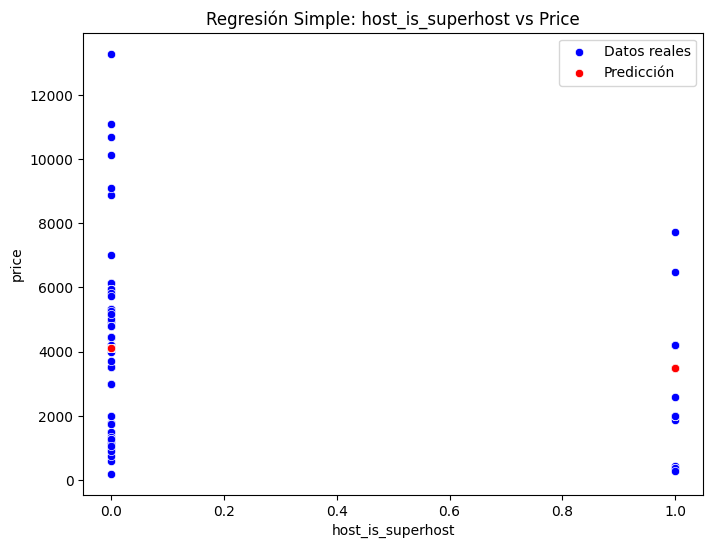

Coeficiente de determinación (R²): 0.01445294104351802
Coeficiente de correlación (sqrt(R²)): 0.12022038530764248


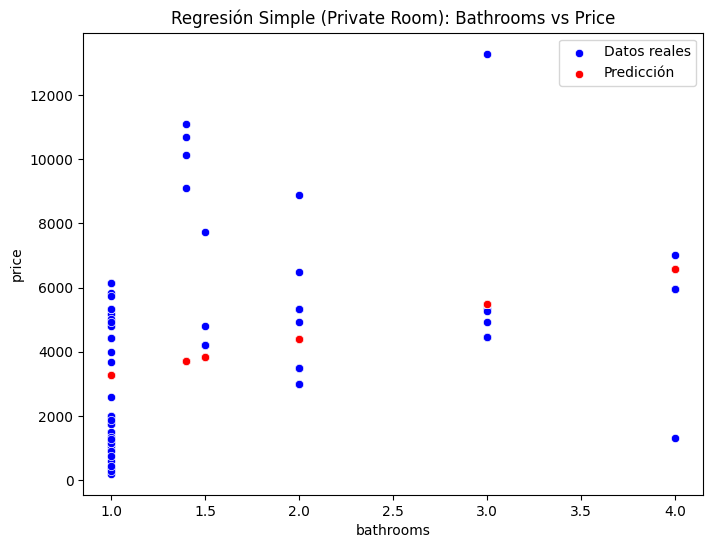

Coeficiente de determinación (R²): 0.16604749935641872
Coeficiente de correlación (sqrt(R²)): 0.4074892628725556


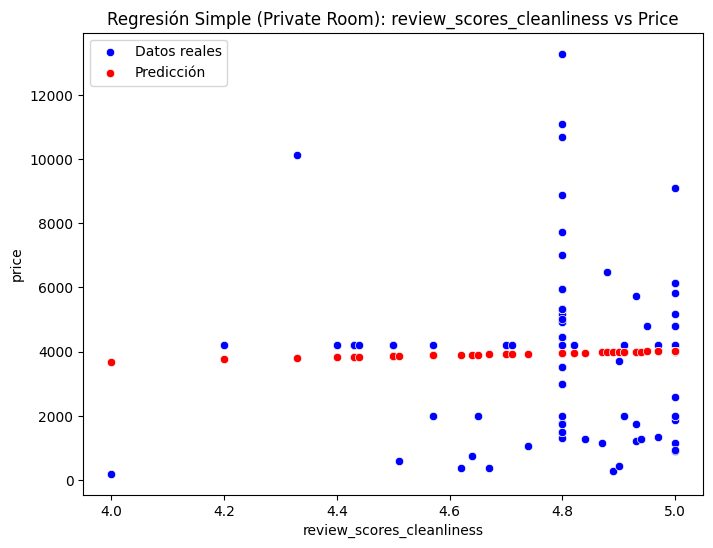

Coeficiente de determinación (R²): 0.0006486966249296122
Coeficiente de correlación (sqrt(R²)): 0.025469523453131436


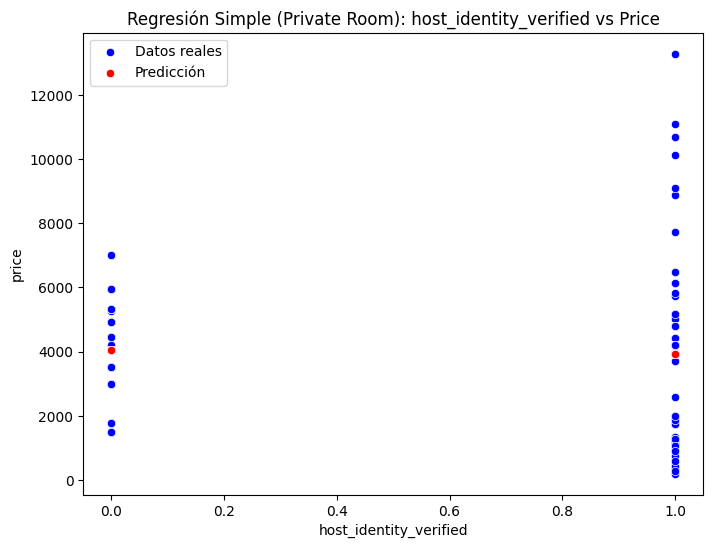

Coeficiente de determinación (R²): 0.000503502038616932
Coeficiente de correlación (sqrt(R²)): 0.022438851098417048


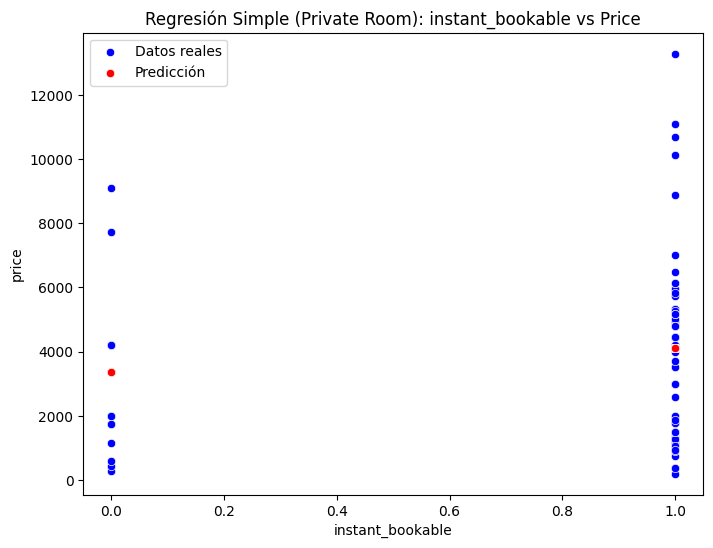

Coeficiente de determinación (R²): 0.016425281646966106
Coeficiente de correlación (sqrt(R²)): 0.1281611549845198


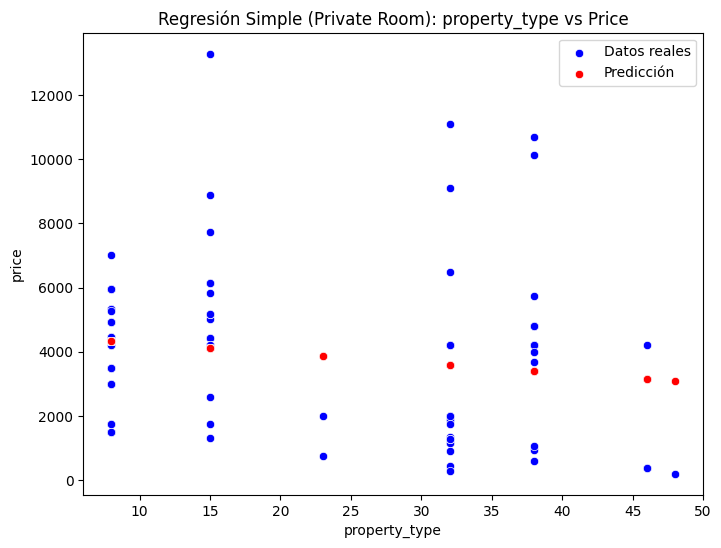

Coeficiente de determinación (R²): 0.03038233226117293
Coeficiente de correlación (sqrt(R²)): 0.17430528466220674


In [138]:
# Private Room
plot_simple_regression(dfHotelRoom, indep_col="host_acceptance_rate", dep_col="price",
                       title="Regresión Simple: Host Acceptance Rate vs Price")

# Ejemplo 2: Usar dfEntireHome y comparar usando "property_type" en el eje X
plot_simple_regression(dfHotelRoom, indep_col="host_is_superhost", dep_col="price",
                       title="Regresión Simple: host_is_superhost vs Price")

# Ejemplo 3: Usar dfPrivateRoom y comparar usando "host_acceptance_rate" en el eje X
plot_simple_regression(dfHotelRoom, indep_col="bathrooms", dep_col="price",
                       title="Regresión Simple (Private Room): Bathrooms vs Price")

plot_simple_regression(dfHotelRoom, indep_col="review_scores_cleanliness", dep_col="price",
                       title="Regresión Simple (Private Room): review_scores_cleanliness vs Price")

plot_simple_regression(dfHotelRoom, indep_col="host_identity_verified", dep_col="price",
                       title="Regresión Simple (Private Room): host_identity_verified vs Price")

plot_simple_regression(dfHotelRoom, indep_col="instant_bookable", dep_col="price",
                       title="Regresión Simple (Private Room): instant_bookable vs Price")

plot_simple_regression(dfHotelRoom, indep_col="property_type", dep_col="price",
                       title="Regresión Simple (Private Room): property_type vs Price")

# Regresión Multiple 

In [139]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

def plot_multiple_regression_single_x(dataframe, indep_cols, dep_col="price", plot_indep_col=None, overall_title="Regresión Múltiple"):
    if plot_indep_col is None:
        raise ValueError("Debes especificar una columna para el eje X (plot_indep_col).")
    
    X = dataframe[indep_cols]
    y = dataframe[dep_col]
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    
    df_plot = dataframe.copy()
    df_plot["pred"] = y_pred
    df_plot = df_plot.sort_values(plot_indep_col)
    
    r2 = model.score(X, y)
    print(f"Coeficiente de determinación (R²): {r2}")
    print(f"Coeficiente de correlación (sqrt(R²)): {np.sqrt(r2)}")
    
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=df_plot[plot_indep_col], y=df_plot[dep_col], color="blue", label="Datos reales")
    sns.scatterplot(x=df_plot[plot_indep_col], y=df_plot["pred"], color="red", label="Datos Predichos")
    plt.title(overall_title)
    plt.xlabel(plot_indep_col)
    plt.ylabel(dep_col)
    plt.legend()
    plt.show()

# Host acceptance rate

Coeficiente de determinación (R²): 0.069755541577875
Coeficiente de correlación (sqrt(R²)): 0.2641127440656263


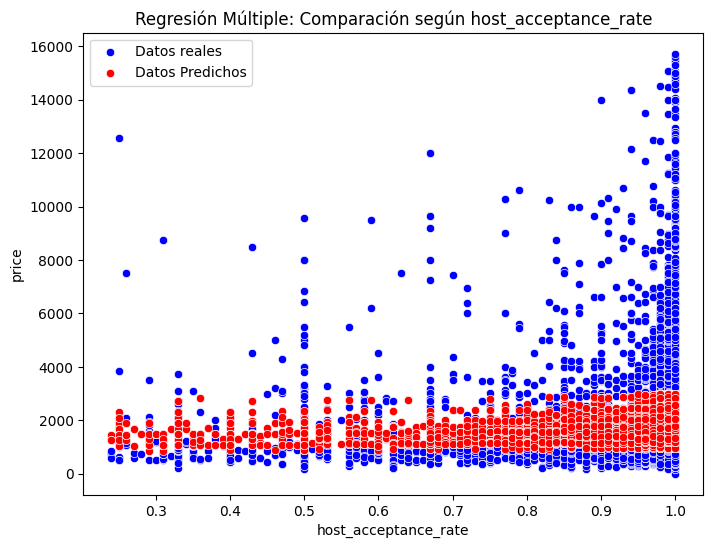

In [148]:
indep_vars = ["host_acceptance_rate", "instant_bookable", "host_is_superhost", "accommodates"]
plot_variable = "host_acceptance_rate"  # La variable única a comparar en el eje X

plot_multiple_regression_single_x(dfEntireHome, indep_cols=indep_vars, dep_col="price", plot_indep_col=plot_variable,
                                  overall_title="Regresión Múltiple: Comparación según host_acceptance_rate")

# Host is superhost

Coeficiente de determinación (R²): 0.2037228033095274
Coeficiente de correlación (sqrt(R²)): 0.45135662541888916


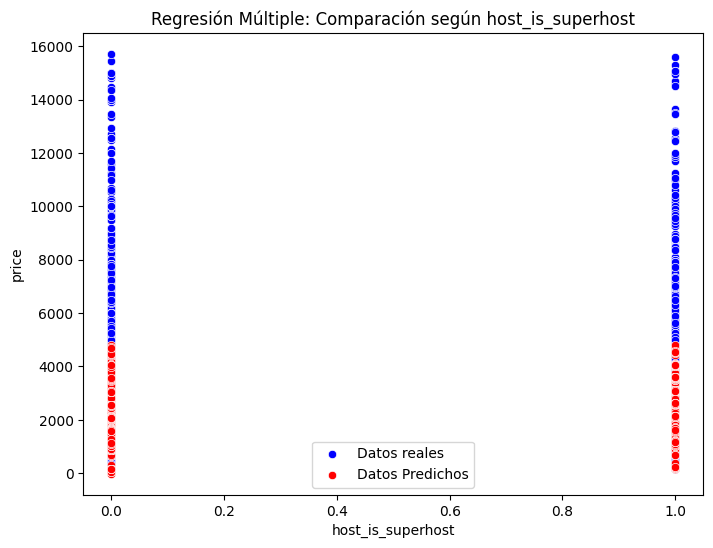

In [149]:
indep_vars = ["host_acceptance_rate", "bathrooms", "host_is_superhost", "property_type"]
plot_variable = "host_is_superhost"  # La variable única a comparar en el eje X

plot_multiple_regression_single_x(dfEntireHome, indep_cols=indep_vars, dep_col="price", plot_indep_col=plot_variable,
                                  overall_title="Regresión Múltiple: Comparación según host_is_superhost")

# Bathrooms

Coeficiente de determinación (R²): 0.20434476754057518
Coeficiente de correlación (sqrt(R²)): 0.4520450945874484


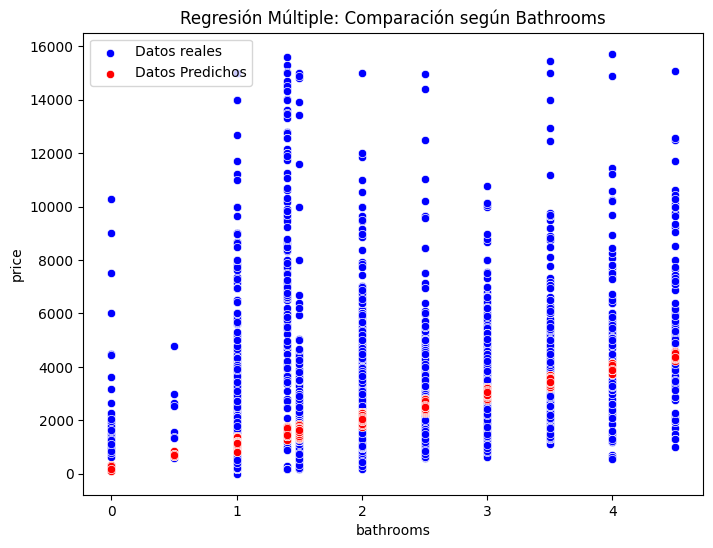

In [ ]:

indep_vars = ["host_acceptance_rate", "bathrooms", "host_is_superhost", "accommodates"]
plot_variable = "bathrooms"  # La variable única a comparar en el eje X

plot_multiple_regression_single_x(dfEntireHome, indep_cols=indep_vars, dep_col="price", plot_indep_col=plot_variable,
                                  overall_title="Regresión Múltiple: Comparación según Bathrooms")

# Review Scores cleanliness

Coeficiente de determinación (R²): 0.20848686984587417
Coeficiente de correlación (sqrt(R²)): 0.45660362443357166


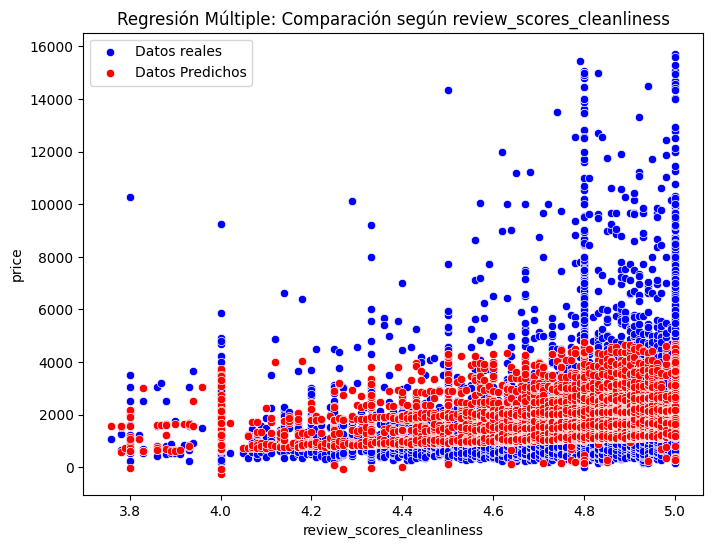

In [150]:
indep_vars = ["bathrooms", "accommodates", "property_type", "review_scores_cleanliness"]
plot_variable = "review_scores_cleanliness"  # La variable única a comparar en el eje X

plot_multiple_regression_single_x(dfEntireHome, indep_cols=indep_vars, dep_col="price", plot_indep_col=plot_variable,
                                  overall_title="Regresión Múltiple: Comparación según review_scores_cleanliness")

# Host identity verified

Coeficiente de determinación (R²): 0.005312320963866801
Coeficiente de correlación (sqrt(R²)): 0.07288567049747709


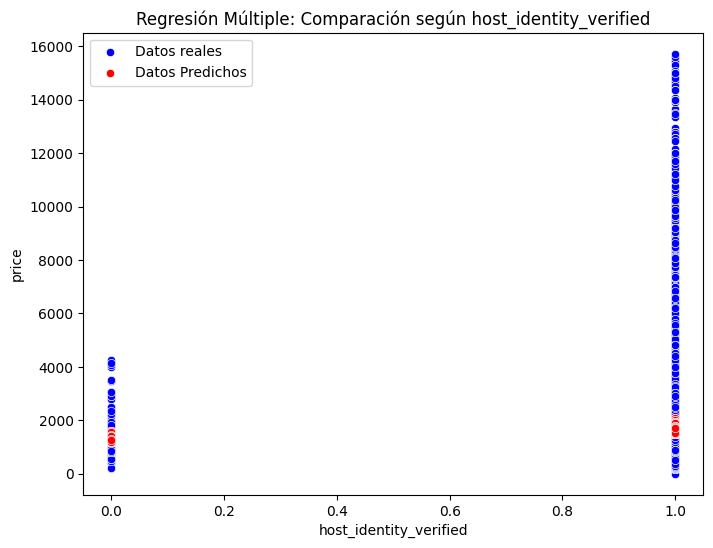

In [154]:
indep_vars = ["host_is_superhost", "property_type", "host_identity_verified", "instant_bookable"]
plot_variable = "host_identity_verified"  # La variable única a comparar en el eje X

plot_multiple_regression_single_x(dfEntireHome, indep_cols=indep_vars, dep_col="price", plot_indep_col=plot_variable,
                                  overall_title="Regresión Múltiple: Comparación según host_identity_verified")

# Instant Bookable

Coeficiente de determinación (R²): 0.07169799869649507
Coeficiente de correlación (sqrt(R²)): 0.26776481975139127


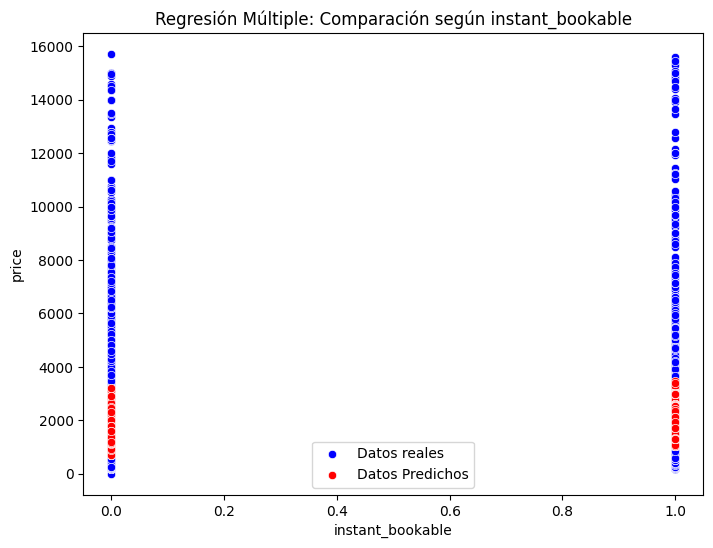

In [157]:
indep_vars = ["accommodates", "property_type", "host_identity_verified", "instant_bookable"]
plot_variable = "instant_bookable"  # La variable única a comparar en el eje X

plot_multiple_regression_single_x(dfEntireHome, indep_cols=indep_vars, dep_col="price", plot_indep_col=plot_variable,
                                  overall_title="Regresión Múltiple: Comparación según instant_bookable")

# Property Type

Coeficiente de determinación (R²): 0.07743137511492959
Coeficiente de correlación (sqrt(R²)): 0.2782649369125215


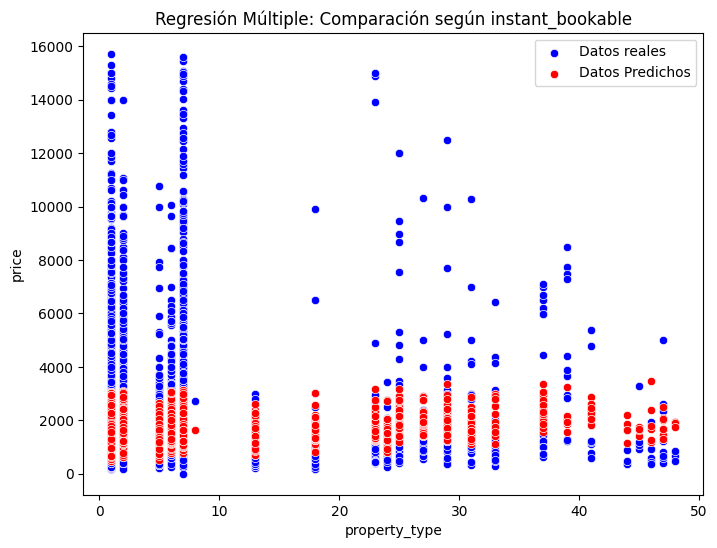

In [158]:
indep_vars = ["accommodates", "property_type", "review_scores_cleanliness", "instant_bookable"]
plot_variable = "property_type"  # La variable única a comparar en el eje X

plot_multiple_regression_single_x(dfEntireHome, indep_cols=indep_vars, dep_col="price", plot_indep_col=plot_variable,
                                  overall_title="Regresión Múltiple: Comparación según instant_bookable")

/Users/alanvalerdi/Developer/HomeWork/Inteligencia_De_Negocios/inteligenciaDeNegociosVenv/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/alanvalerdi/Developer/HomeWork/Inteligencia_De_Negocios/inteligenciaDeNegociosVenv/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/alanvalerdi/Developer/HomeWork/Inteligencia_De_Negocios/inteligenciaDeNegociosVenv/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mo

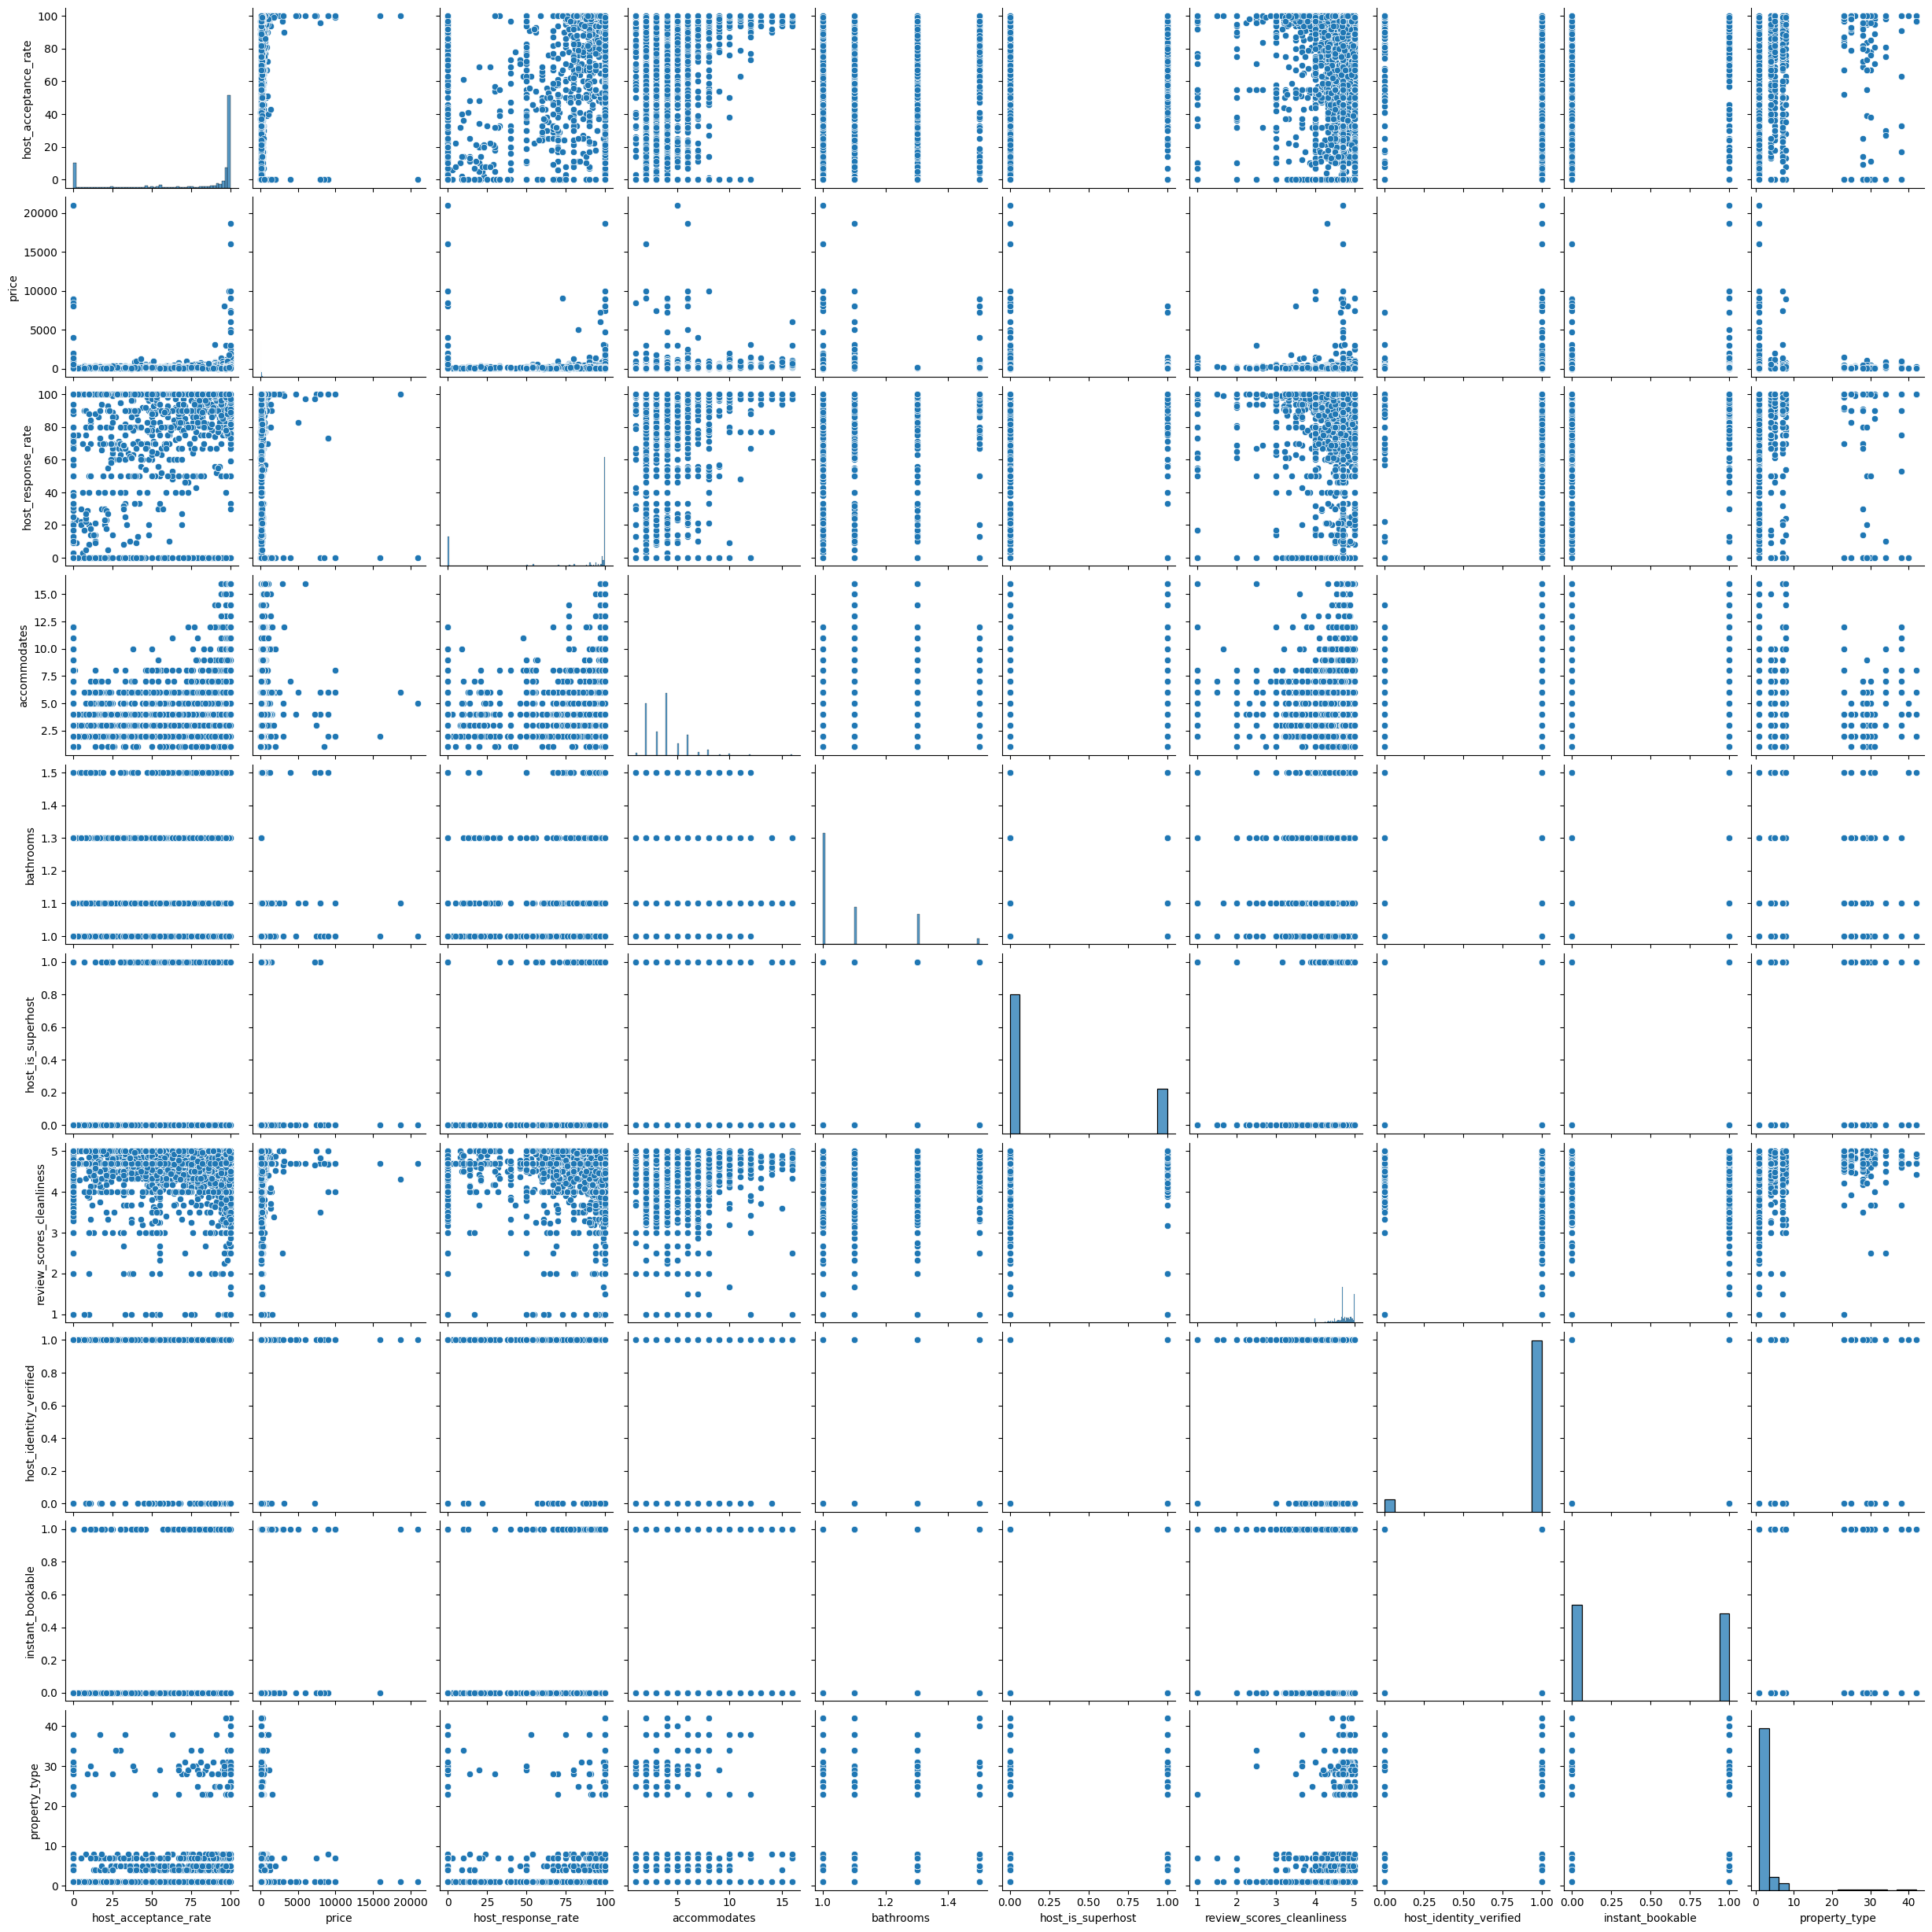

In [107]:
sns.pairplot(dfEntireHome)

# Graficas de Correlaciones para cada DataFrame

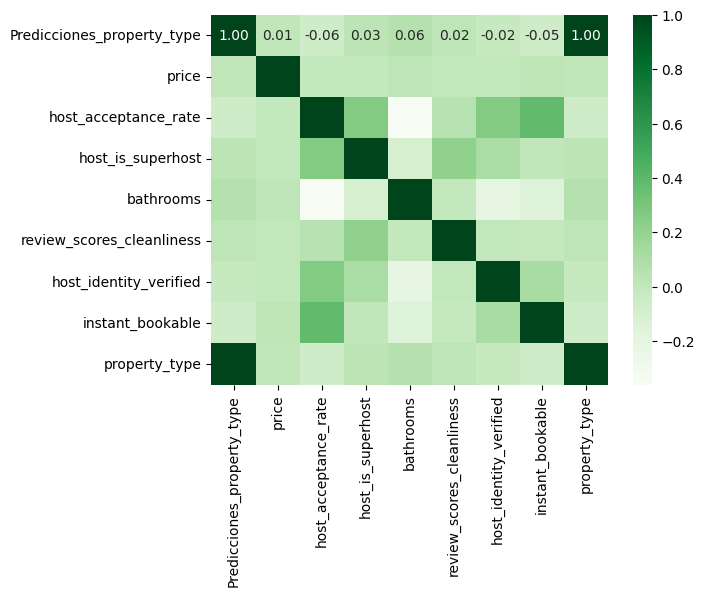

In [ ]:
corrFactorsEntireHome = dfEntireHomeCuantity.corr()
corrFactorsEntireHome1 = abs(corrFactorsEntireHome) 
heatMapCorrFactorsEntireHome = sns.heatmap(corrFactorsEntireHome, cmap="Greens", annot=True, fmt=".2f")

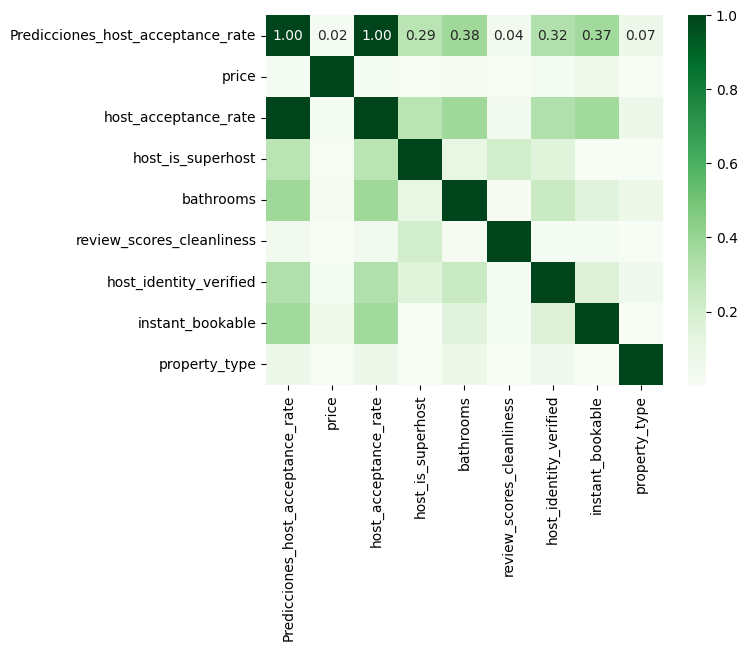

In [38]:
corrFactorsEntireHome = df.corr()
corrFactorsEntireHome1 = abs(corrFactorsEntireHome)
heatMapCorrFactorsEntireHome = sns.heatmap(corrFactorsEntireHome1, cmap="Greens", annot=True, fmt=".2f")